In [1]:
import torch 
import torch.nn as nn

from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn.utils.parametrizations import spectral_norm
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm

# For embeddings
import seaborn as sns
from sklearn.manifold import TSNE

# Task 2: Training a GAN

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generate datasets and apply transformations to them
transform = transforms.Compose([
  transforms.Resize((32,32)),
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

dataset_train = FashionMNIST('./data', train=True, download=True, transform=transform)

In [3]:
# Create the Generator model
class Generator(nn.Module):
  def __init__(self, z_dim=100):
    super(Generator, self).__init__()
    self.label_embedding = nn.Embedding(10, z_dim)
    self.fc1 = nn.Linear(in_features=200, out_features=8192) # output: 512 x 4 x 4
    self.conv1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(5,5)) # output: 256 x 8 x 8
    self.batch_norm1 = nn.BatchNorm2d(num_features=256)
    self.conv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(9,9)) # output: 128 x 16 x 16
    self.batch_norm2 = nn.BatchNorm2d(num_features=128)
    self.conv3 = nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size=(17,17)) # output: 1 x 32 x 32
    self.batch_norm3 = nn.BatchNorm2d(num_features=1)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self, z, y):
    # Projection + Reshape
    label = self.label_embedding(y)
    #print("z", z.shape)
    #print("label", label.shape)
    if len(label.shape) == 1:
        label = label.unsqueeze(0)  # Add batch dimension
    combined = torch.concatenate((z, label), dim=1)
    out = self.fc1(combined)
    out = torch.reshape(out, (out.shape[0], 512, 4, 4))

    # Conv 1
    out = self.conv1(out)
    out = self.batch_norm1(out)
    out = self.relu(out)

    # Conv 2
    out = self.conv2(out)
    out = self.batch_norm2(out)
    out = self.relu(out)

    # Conv 3
    out = self.conv3(out)
    out = self.batch_norm3(out)
    out = self.tanh(out)

    return out

In [4]:
# Create the Discriminator model
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    # we have 10 classes and we want 64 embeddings
    self.conv1 = spectral_norm(nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(17,17))) # output: 64 x 16 x 16
    self.batch_norm1 = nn.BatchNorm2d(num_features=64)
    self.label_embedding = nn.Embedding(num_embeddings=10, embedding_dim=64)  # output: 128 x 16 x 16
    self.conv2 = spectral_norm(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(9,9))) # output: 256 x 8 x 8
    self.batch_norm2 = nn.BatchNorm2d(num_features=256)
    self.conv3 = spectral_norm(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(5,5))) # output: 512 x 4 x 4
    self.batch_norm3 = nn.BatchNorm2d(num_features=512)
    self.fc1 = nn.Linear(in_features=8192, out_features=1)
    self.leaky_relu = nn.LeakyReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x, y):
  
    # Conv 1
    out = self.conv1(x)
    out = self.batch_norm1(out)
    out = self.leaky_relu(out)

    # Add the label to conv1 output 64 x 16 x 16 -> 128 x 16 x 16
    label = self.label_embedding(y)
    # Expand embeddings to match the spatial dimensions and create a new dimension for concatenation
    batch, _, height, width = out.shape
    label = label.unsqueeze(-1).unsqueeze(-1).expand(batch, 64, height, width) # Output: 128 x 16 x 16
    combined = torch.concatenate((out, label), dim=1) # concatenate along channel dimension

    # Conv 2
    out = self.conv2(combined)
    out = self.batch_norm2(out)
    out = self.leaky_relu(out)

    # Conv 3
    out = self.conv3(out)
    out = self.batch_norm3(out)
    out = self.leaky_relu(out)

    # Classification
    out = torch.flatten(out, start_dim=1, end_dim=-1) # do not flatten batch
    out = self.fc1(out)
    out = self.sigmoid(out) # guide sage leaky relu aber why

    return out

In [5]:
# Gradient ascent
def discriminator_reward(decision_x, decision_x_hat):
  loss = torch.mean(torch.log(decision_x) + torch.log(1 - decision_x_hat))
  return loss

# Gradient ascent
def generator_reward(decision_x_hat):
  loss = torch.mean(torch.log(decision_x_hat))
  return loss

In [6]:
# Visualizations

def visualize_rewards(G_rewards, D_rewards):
  plt.plot(G_rewards, label="Generator")
  plt.plot(D_rewards, label="Discriminator")
  plt.xlabel("Steps")
  plt.ylabel("Reward")
  plt.legend()
  plt.show()

def visualize_samples(generator, dist, z_dim=100):
  classes = ['T-shirt', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  fig, axs = plt.subplots(1, 10, figsize=(20,10))
  generator.eval()
  for i in range(10):
    z = dist.sample(sample_shape=torch.Size([1, z_dim])).to(device)
    y = torch.tensor(i).to(device)
    x_hat = generator(z, y)

    axs[i].imshow(x_hat.cpu().detach().numpy().squeeze(), cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(classes[i])
  plt.show()

def visualize_model_performance(x_hat_evolutions, epochs):
  classes = ['T-shirt', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  fig, axs = plt.subplots(epochs, 10, figsize=(20,epochs*2))

  for i in range(epochs):
    for j  in range(10):
      axs[i, j].imshow(x_hat_evolutions[i][j].cpu().detach().numpy().squeeze(), cmap='gray')
      axs[i, j].axis('off')
      axs[i, j].set_title(classes[j])
      
    axs[i][0].text(-0.5, 0.5, f"Epoch {i+1}", va='center', ha='right', transform=axs[i][0].transAxes)
  plt.show()


def visualize_D_accuracy(D_x_accuracy, D_x_hat_accuracy):
  plt.plot(D_x_accuracy, label="Real Image")
  plt.plot(D_x_hat_accuracy, label="Fake Image")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Real Image belief")
  plt.title("Accuracy: How well can Discriminator differentiate between real and fake images")

In [7]:
def training_routine(epochs=15, batch_size=128, lr=0.0001, beta=0.5, z_dim=100 ):
  
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
  dist = torch.distributions.Normal(0, 1)

  # Generate a latent z, which will be used to evaluate the model
  consistent_z = dist.sample(sample_shape=torch.Size([1, z_dim])).to(device)
  x_hat_evolutions = [] # List that saves the created images of consistent_z over the epochs

  generator = Generator().to(device)
  discriminator = Discriminator().to(device)

  generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta, 0.999), maximize=True) # Gradient ascent
  discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta, 0.999), maximize=True) # Gradient ascent

  generator.train()
  discriminator.train()
  D_x_accuracy = []
  D_x_hat_accuracy = []
  D_rewards =  []
  G_rewards =  []
  for epoch in range(epochs):
    x_hat_evolution = []
    D_epoch_x_accuracy = []
    D_epoch_x_hat_accuracy = []
    D_epoch_reward = []
    G_epoch_reward = []
    for i, sample in tqdm(enumerate(dataloader_train)):
      x = sample[0].to(device)
      y = sample[1].to(device)

      generator_optimizer.zero_grad()
      discriminator_optimizer.zero_grad()

      # Draw random value from distribution
      z = dist.sample(sample_shape=torch.Size([batch_size, z_dim])).to(device)

      ### UPDATE DISCRIMINATOR ###
      x_hat = generator(z, y)
      decision_x = discriminator(x, y)
      decision_x_hat = discriminator(x_hat.detach(), y) # Detach x_hat to prevent backpropagation through generator
      D_epoch_x_accuracy.append(np.mean(decision_x.cpu().detach().numpy()).item())
      D_epoch_x_hat_accuracy.append(np.mean(decision_x_hat.cpu().detach().numpy()).item())

      D_reward = discriminator_reward(decision_x, decision_x_hat)
      D_reward.backward(retain_graph=True) # Have to set this, or the second backward pass will fail
      discriminator_optimizer.step()
      D_rewards.append(D_reward.cpu().detach().numpy())
      D_epoch_reward.append(D_reward.cpu().detach().numpy())

      ### UPDATE GENERATOR ###
      x_hat = generator(z, y)
      decision_x_hat = discriminator(x_hat, y)
      G_reward = generator_reward(decision_x_hat)
      G_reward.backward()
      generator_optimizer.step()
      G_rewards.append(G_reward.cpu().detach().numpy())
      G_epoch_reward.append(G_reward.cpu().detach().numpy())

    # Generate images to show the evolution of the model over multiple epochs
    for c in (range(10)):
      y_iter = torch.tensor([c]).to(device)
      x_hat_evolution.append(generator(consistent_z, y_iter))
    x_hat_evolutions.append(x_hat_evolution)


    visualize_rewards(G_rewards, D_rewards)
    visualize_samples(generator, dist)
    D_x_accuracy.append(np.mean(D_epoch_x_accuracy))
    D_x_hat_accuracy.append(np.mean(D_epoch_x_hat_accuracy))
    print()
    print(f"Epoch [{epoch+1}/{epochs}]  Generator reward: {np.mean(G_epoch_reward):.2f}, Discriminator reward: {np.mean(D_epoch_reward):.2f}")
  
  visualize_D_accuracy(D_x_accuracy, D_x_hat_accuracy)
  visualize_model_performance(x_hat_evolutions, epochs=epochs)
  
  return generator, discriminator, x_hat_evolutions, D_x_accuracy, D_x_hat_accuracy

It can be clearly seen, that the discriminator is performing worse and worse as the generator outputs improve in qualitsy. It moves closes and closer to the nash equilibrium of 50% accuracy for both real and fake images

No Generator and Discriminator exists: training model


0it [00:00, ?it/s]c:\Users\adria\anaconda3\envs\genai\Lib\site-packages\torch\nn\modules\conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv_transpose2d(
c:\Users\adria\anaconda3\envs\genai\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\adria\anaconda3\envs\genai\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed

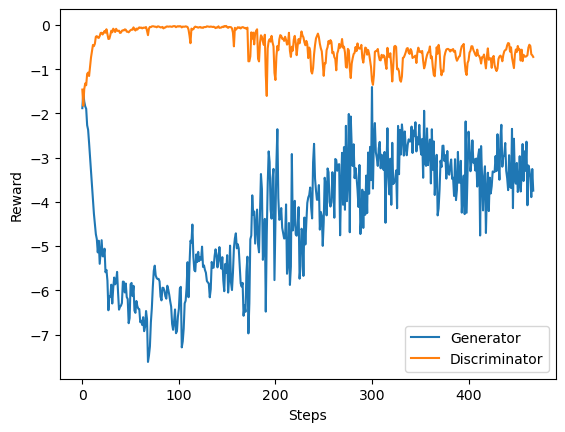

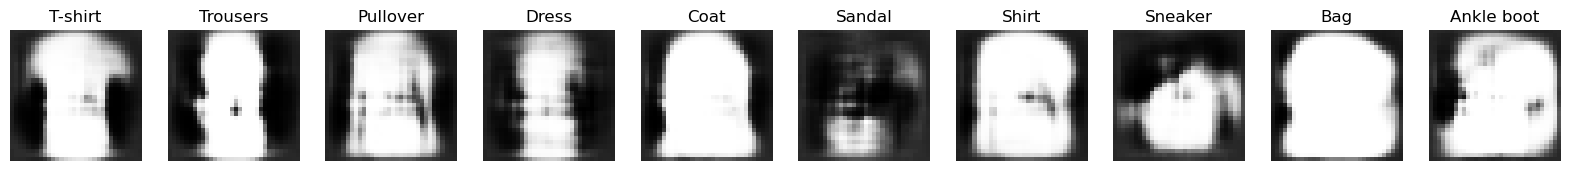


Epoch [1/15]  Generator reward: -4.32, Discriminator reward: -0.47


468it [01:23,  5.60it/s]


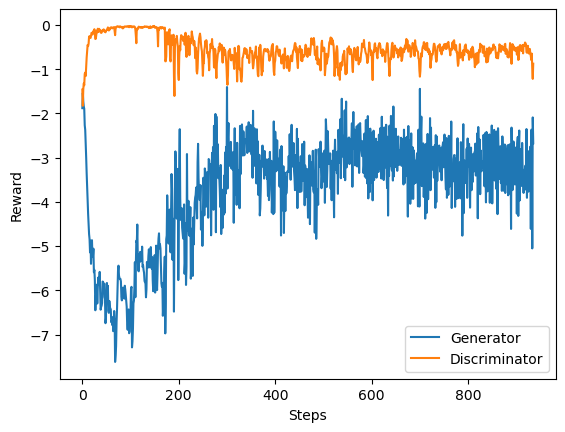

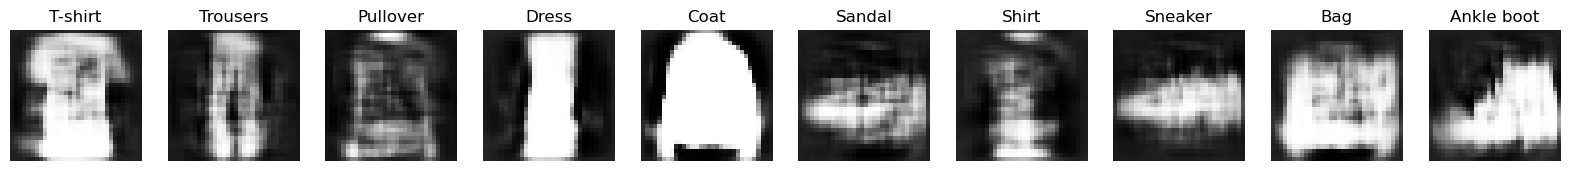


Epoch [2/15]  Generator reward: -3.10, Discriminator reward: -0.61


468it [01:26,  5.40it/s]


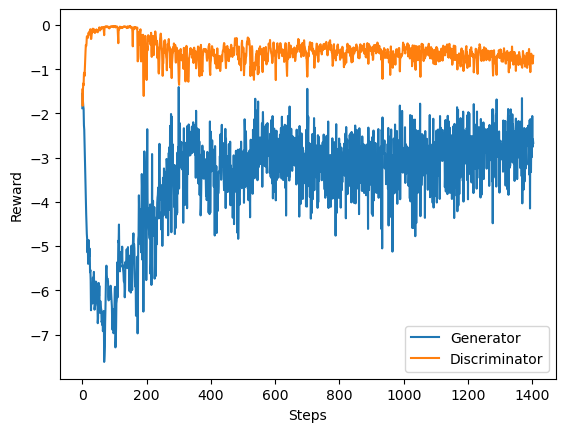

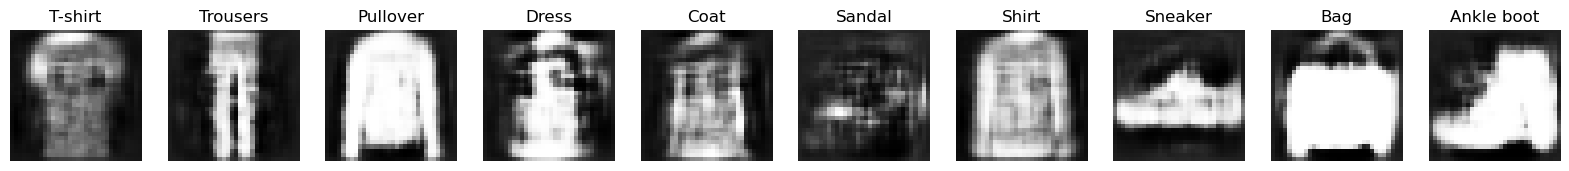


Epoch [3/15]  Generator reward: -2.92, Discriminator reward: -0.69


468it [01:24,  5.55it/s]


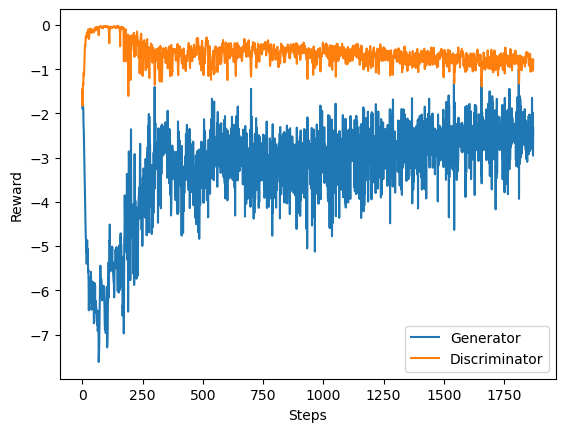

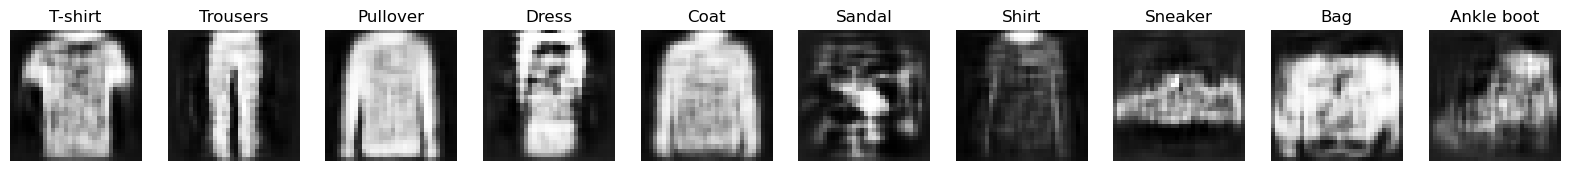


Epoch [4/15]  Generator reward: -2.55, Discriminator reward: -0.78


468it [01:24,  5.56it/s]


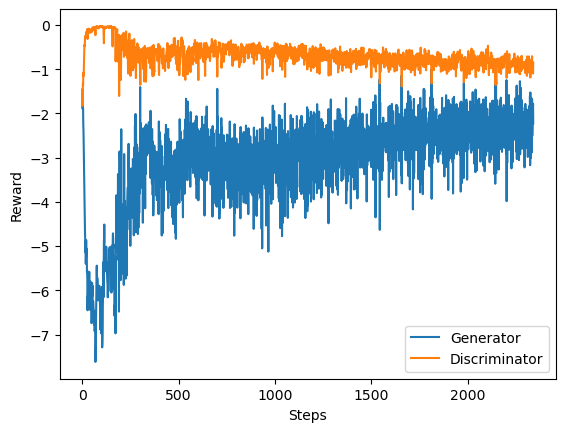

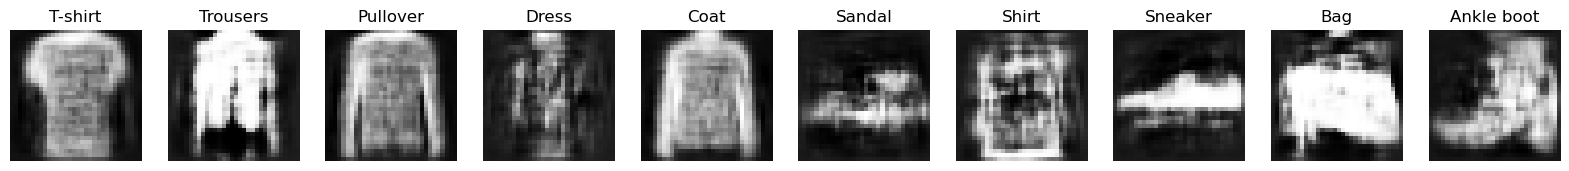


Epoch [5/15]  Generator reward: -2.35, Discriminator reward: -0.86


468it [01:24,  5.54it/s]


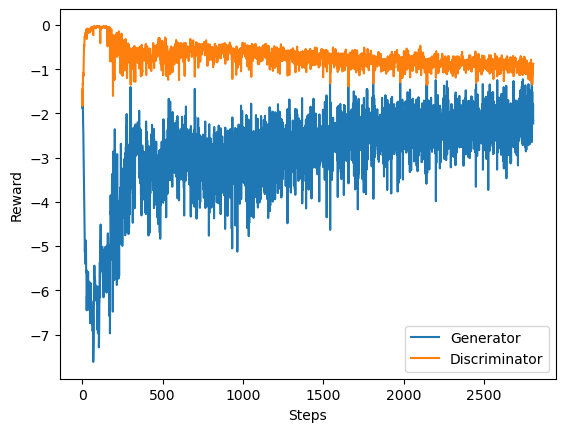

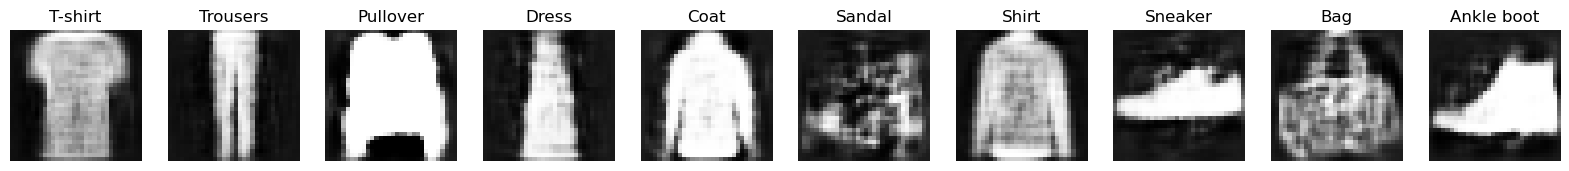


Epoch [6/15]  Generator reward: -2.19, Discriminator reward: -0.90


468it [01:28,  5.27it/s]


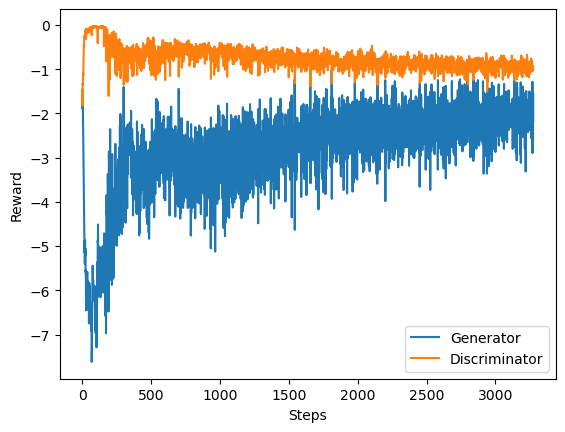

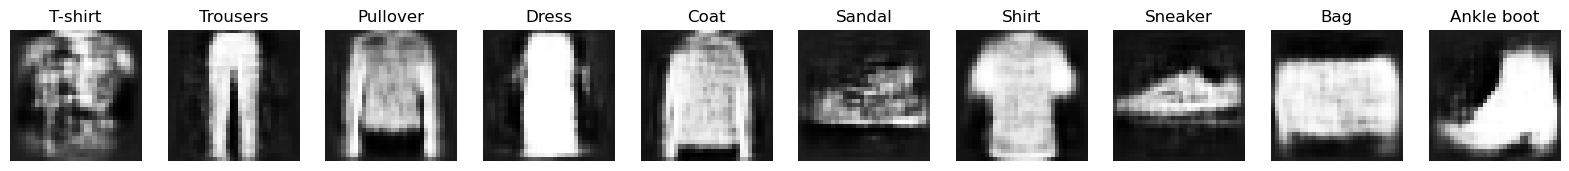


Epoch [7/15]  Generator reward: -2.08, Discriminator reward: -0.94


468it [01:22,  5.64it/s]


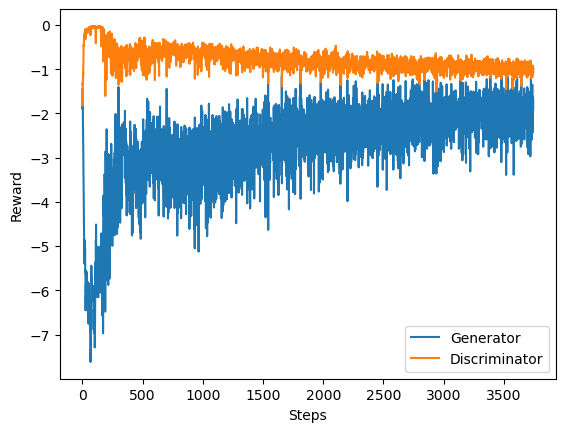

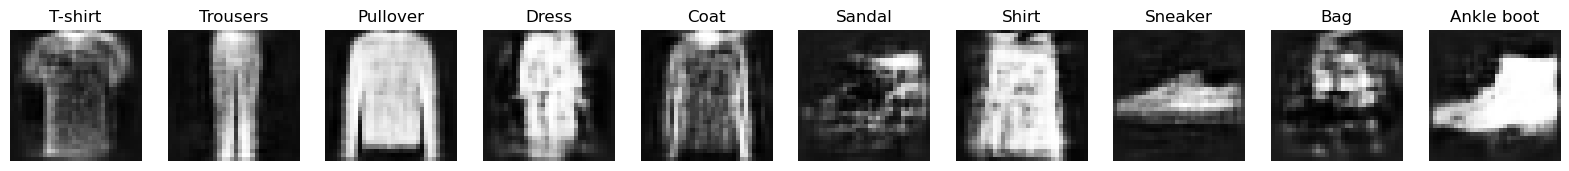


Epoch [8/15]  Generator reward: -2.00, Discriminator reward: -0.97


468it [01:22,  5.69it/s]


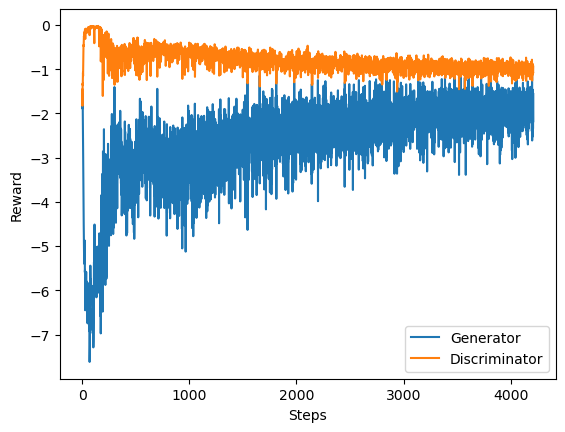

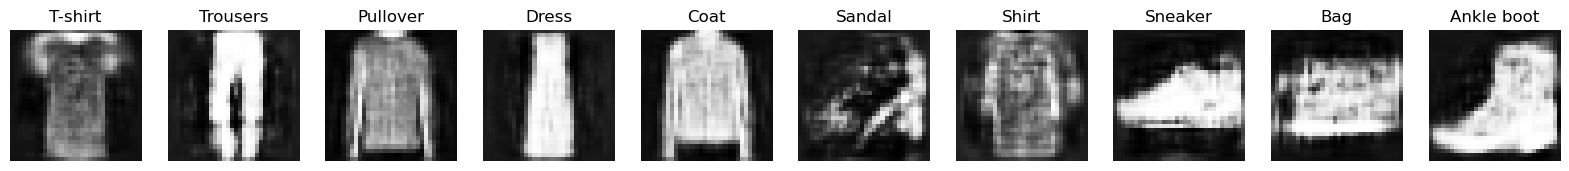


Epoch [9/15]  Generator reward: -1.95, Discriminator reward: -0.97


468it [01:20,  5.80it/s]


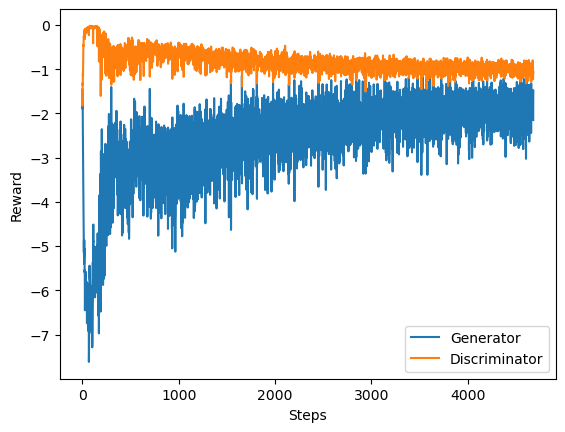

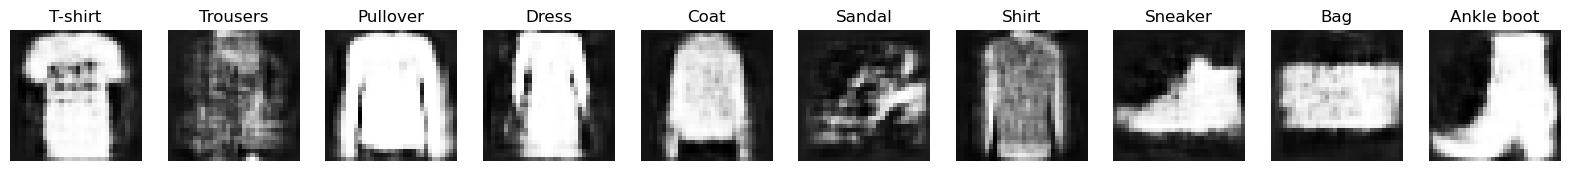


Epoch [10/15]  Generator reward: -1.90, Discriminator reward: -1.00


468it [01:22,  5.66it/s]


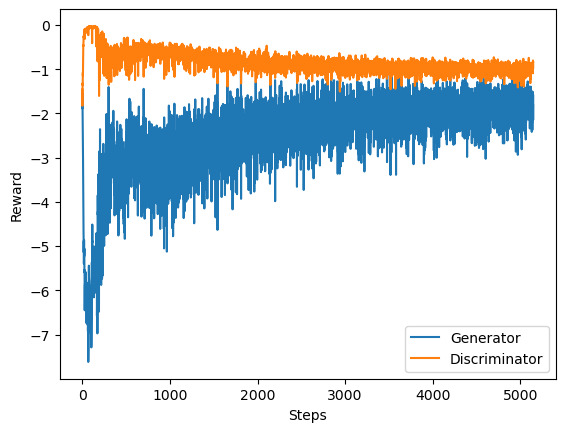

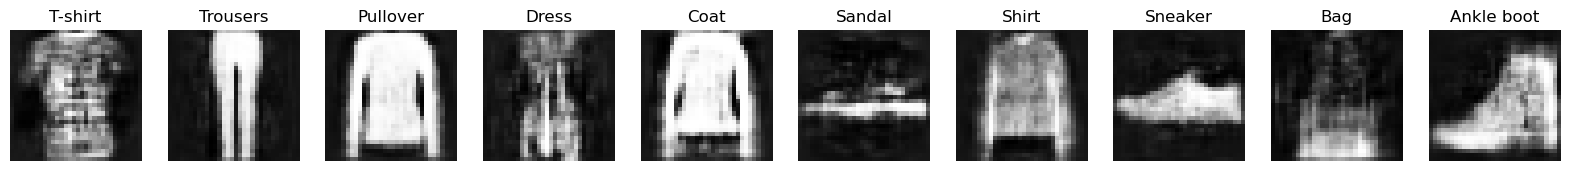


Epoch [11/15]  Generator reward: -1.86, Discriminator reward: -1.01


468it [01:22,  5.67it/s]


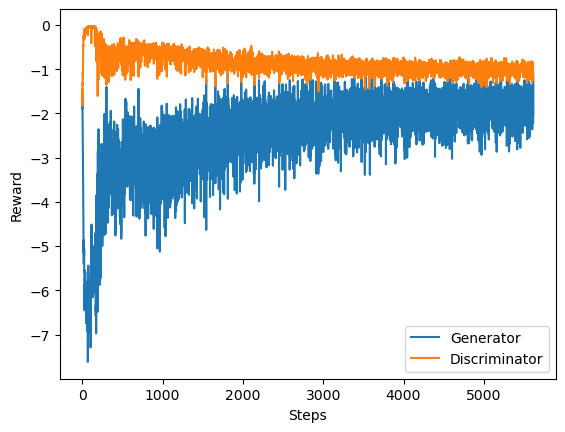

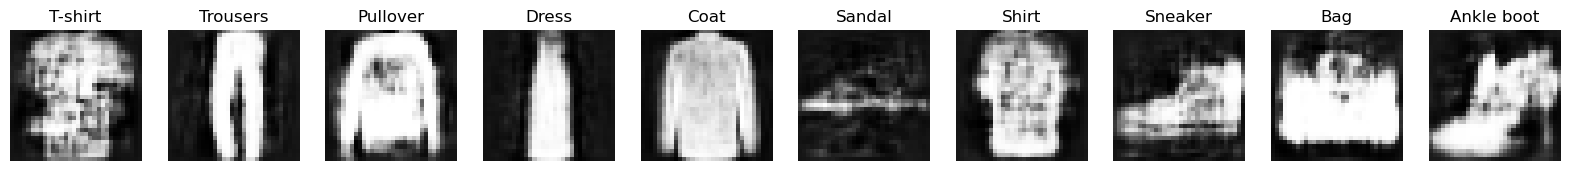


Epoch [12/15]  Generator reward: -1.86, Discriminator reward: -1.01


468it [01:20,  5.83it/s]


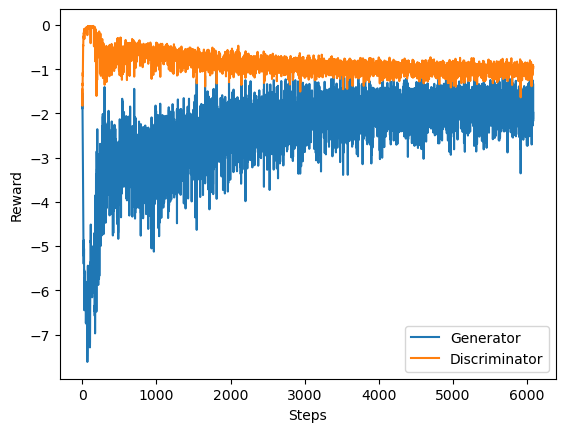

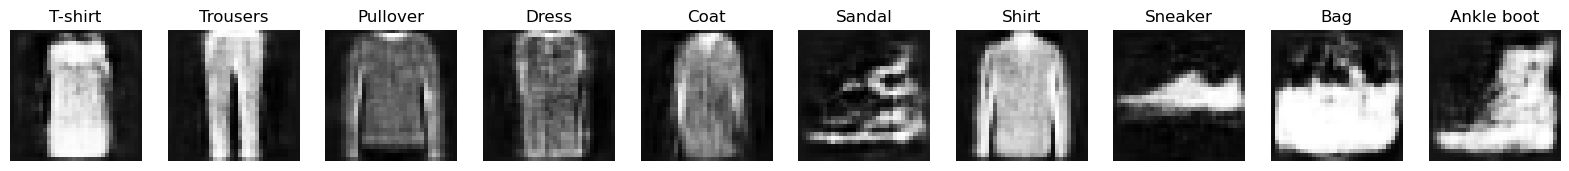


Epoch [13/15]  Generator reward: -1.84, Discriminator reward: -1.02


468it [01:19,  5.91it/s]


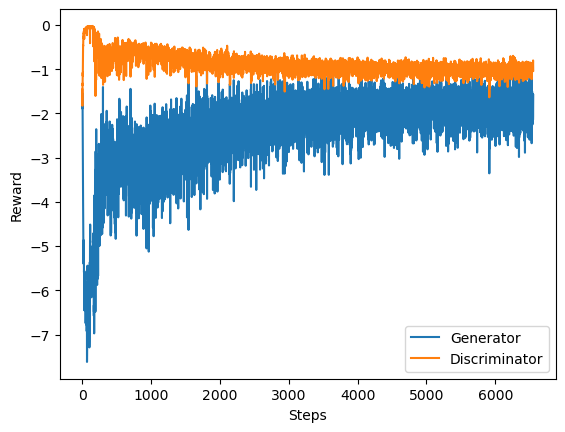

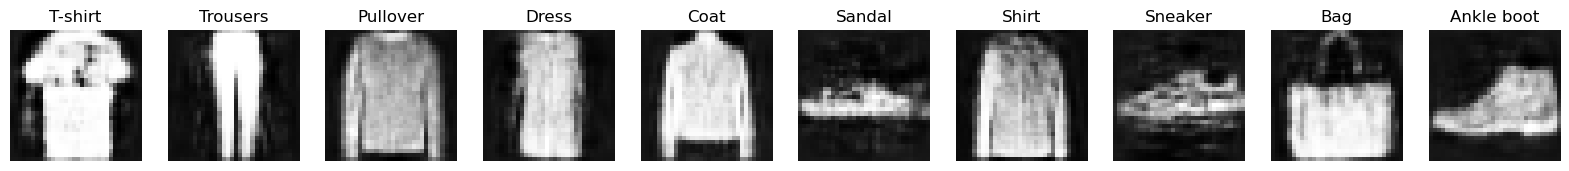


Epoch [14/15]  Generator reward: -1.84, Discriminator reward: -1.00


468it [01:22,  5.69it/s]


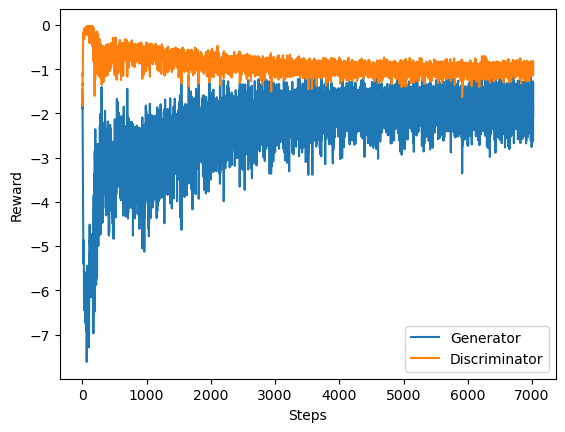

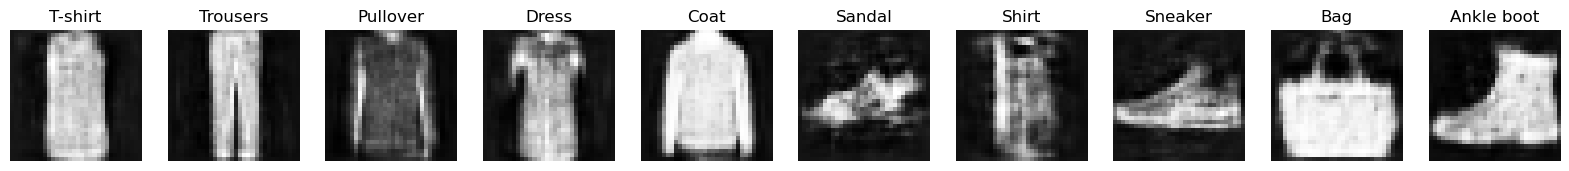


Epoch [15/15]  Generator reward: -1.87, Discriminator reward: -1.00


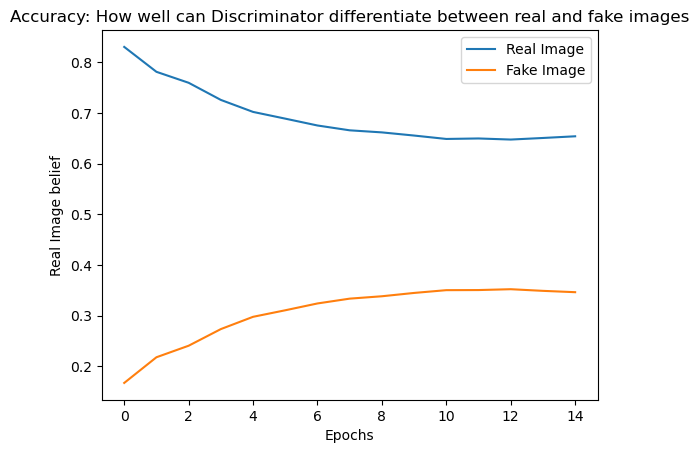

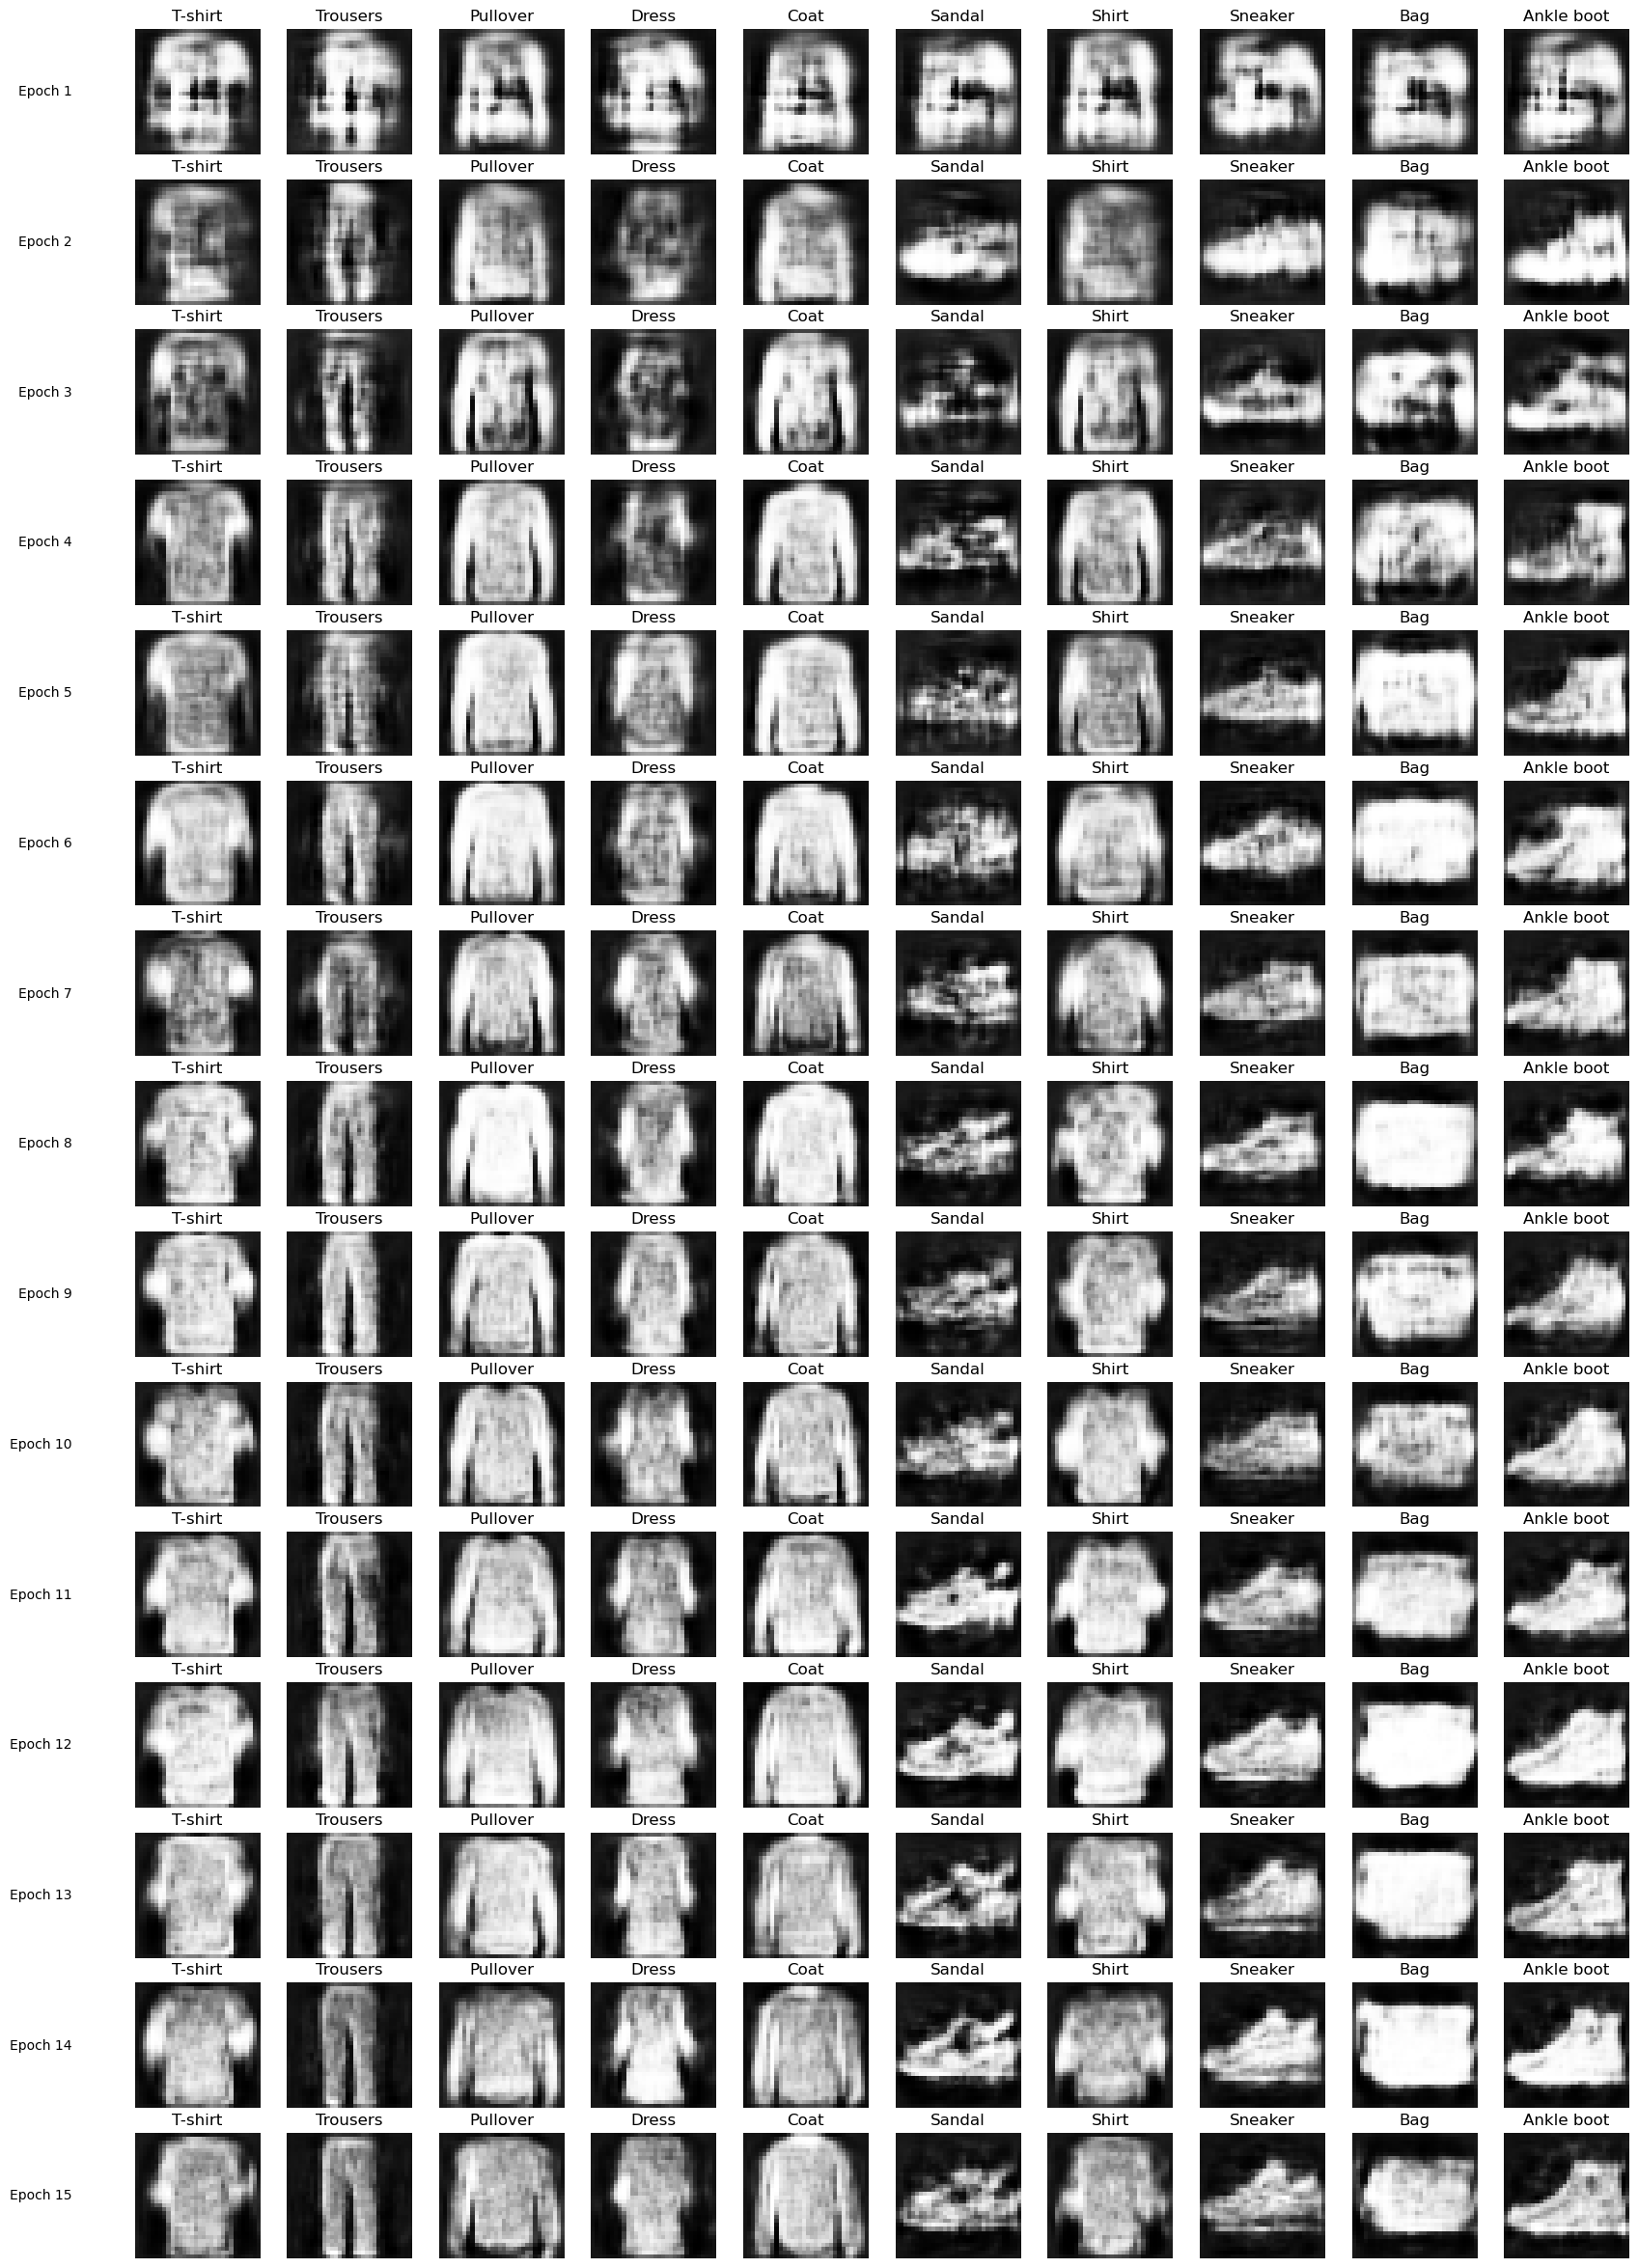

In [8]:
try:
  # Reload the generator
  generator = Generator().to(device)
  generator.load_state_dict(torch.load('generator.pth'))
  generator.eval()

  # Reload the discriminator
  discriminator = Discriminator().to(device)
  discriminator.load_state_dict(torch.load('discriminator.pth'))
  discriminator.eval()
  print("Generator and Discriminator loaded")
except:
  print("No Generator and Discriminator exists: training model")
  generator, discriminator, x_hat_evolutions, D_x_accuracy, D_x_hat_accuracy  = training_routine()
  # Save the trained generator and discriminator
  torch.save(generator.state_dict(), 'generator.pth')
  torch.save(discriminator.state_dict(), 'discriminator.pth')

### t-SNE embedding

In [9]:
class Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x, return_softmax=False):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        if return_softmax:
            x = F.softmax(x, dim=1)
        return x

Epoch [1/10], Step [1/1200], Loss: 2.3007
Epoch [1/10], Step [101/1200], Loss: 0.7304
Epoch [1/10], Step [201/1200], Loss: 0.5705
Epoch [1/10], Step [301/1200], Loss: 0.4935
Epoch [1/10], Step [401/1200], Loss: 0.3800
Epoch [1/10], Step [501/1200], Loss: 0.4600
Epoch [1/10], Step [601/1200], Loss: 0.5311
Epoch [1/10], Step [701/1200], Loss: 0.4733
Epoch [1/10], Step [801/1200], Loss: 0.4683
Epoch [1/10], Step [901/1200], Loss: 0.4314
Epoch [1/10], Step [1001/1200], Loss: 0.4108
Epoch [1/10], Step [1101/1200], Loss: 0.3957
Epoch [2/10], Step [1/1200], Loss: 0.2783
Epoch [2/10], Step [101/1200], Loss: 0.6019
Epoch [2/10], Step [201/1200], Loss: 0.4130
Epoch [2/10], Step [301/1200], Loss: 0.6427
Epoch [2/10], Step [401/1200], Loss: 0.3404
Epoch [2/10], Step [501/1200], Loss: 0.4351
Epoch [2/10], Step [601/1200], Loss: 0.4803
Epoch [2/10], Step [701/1200], Loss: 0.3660
Epoch [2/10], Step [801/1200], Loss: 0.6021
Epoch [2/10], Step [901/1200], Loss: 0.4052
Epoch [2/10], Step [1001/1200], Lo

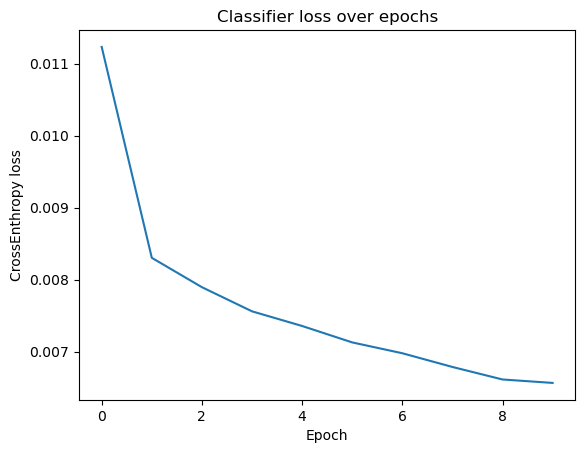

In [10]:
# Hyperparameter
batch_size = 50
lr = 0.01
epochs = 10
num_classes = 10


# Train the classifier
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
classifier = Classifier(num_classes=num_classes).to(device)
optimizer_C = torch.optim.Adam(classifier.parameters(), lr=lr)
criterion_C = nn.CrossEntropyLoss()

losses = []
for epoch in range(epochs):
    epoch_loss = 0
    classifier.train()
    for i, (x, y) in enumerate(dataloader_train, 0):
        x, y = x.to(device), y.to(device)
        optimizer_C.zero_grad()
        outputs = classifier(x)
        loss = criterion_C(outputs, y)
        loss.backward()
        optimizer_C.step()

        epoch_loss += np.sum(loss.cpu().detach().numpy())
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(dataloader_train)}], Loss: {loss.item():.4f}')
    
    losses.append(epoch_loss / (len(dataloader_train) * batch_size) )

# Save the trained classifier
torch.save(classifier.state_dict(), 'classifier.pth')

plt.plot(losses)
plt.title("Classifier loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("CrossEnthropy loss")
plt.show()


In [11]:
# Reload the classifier
classifier = Classifier().to(device)
classifier.load_state_dict(torch.load('classifier.pth'))
classifier.eval()

# Create a feature extractor to extract the activations after the pooling layer
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            model.conv1,
            model.relu,
            model.pool,
            model.conv2,
            model.relu,
            model.pool
        )
    def forward(self, x):
      return self.features(x)

feature_extractor = FeatureExtractor(classifier).to(device)

# Function that extracts the features (activations) after the pooling layer
def extract_features(data_loader):
    features = []
    labels = []
    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            output = feature_extractor(data).view(data.size(0), -1)
            features.append(output.cpu())
            labels.append(label)
    return torch.cat(features, dim=0), torch.cat(labels, dim=0)

In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

num_images = 500
num_classes = 5
generated_images = []
generated_labels = []

dist = torch.distributions.Normal(0, 1)
for i in range(num_images):
    z = dist.sample(sample_shape=torch.Size([1, 100])).to(device)
    label = torch.tensor([(i % 5)]).to(device)
    with torch.no_grad():
        x_hat = generator(z, label).detach().cpu()
    generated_images.append(x_hat)
    generated_labels.append(label.item())

generated_images = torch.cat(generated_images, dim=0)
generated_labels = torch.tensor(generated_labels)


# Generate a subset for both the training and test set containing 500 samples each
dataset_test = FashionMNIST(root='data', train=False, download=True, transform=transform)
indices_train = []
indices_test = []
for class_index in range(num_classes):
    class_indices_train = [i for i, label in enumerate(dataset_train.targets) if label == class_index]
    class_indices_test = [i for i, label in enumerate(dataset_test.targets) if label == class_index]
    indices_train.extend(class_indices_train[:int(num_images/num_classes)])
    indices_test.extend(class_indices_test[:int(num_images/num_classes)])

# Create a subset
subset_train = Subset(dataset_train, indices_train)
subset_test = Subset(dataset_test, indices_test)
dataset_generated = [(generated_images[i], generated_labels[i]) for i in range(num_images)]

# Create dataloader
dataloader_subset_train = DataLoader(subset_train, batch_size=batch_size, shuffle=False)
dataloader_subset_test = DataLoader(subset_test, batch_size=batch_size, shuffle=False)
dataloader_generated = DataLoader(dataset_generated, batch_size=batch_size, shuffle=False)

print(f"Generated images size: {len(generated_images)}")
print(f"Subset train size: {len(subset_train)}")
print(f"Subset test size: {len(subset_test)}")

Generated images size: 500
Subset train size: 500
Subset test size: 500


In [13]:
# Plot the classification accuracy of the classifier on the generated data
classifier.eval()
with torch.no_grad():
  correct_classified = 0
  for x, y in dataloader_generated:
    x, y = x.to(device), y.to(device)
    y_pred = classifier(x, return_softmax=True)

    y_pred = torch.argmax(y_pred, dim=1) # take the highest value from softmax output as class label
    for i in range(batch_size):
      if y_pred[i] == y[i]:
        correct_classified +=1
  accuracy = correct_classified / (len(dataloader_generated) * batch_size)
  print(f"Classification accuracy on generated images: {accuracy*100:.2f}%")

Classification accuracy on generated images: 63.60%


In [14]:
# Extract features for train split, test split, and generated images
train_features, train_labels = extract_features(dataloader_subset_train)
test_features, test_labels = extract_features(dataloader_subset_test)
generated_features, generated_labels = extract_features(dataloader_generated)

# Combine all features and labels
all_features = np.concatenate([train_features, test_features, generated_features])
all_labels = np.concatenate([train_labels, test_labels, generated_labels])
all_domains = np.concatenate([
    np.full(len(train_features), 'Train'),
    np.full(len(test_features), 'Test'),
    np.full(len(generated_features), 'Generated')
])

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=25)
tsne_results = tsne.fit_transform(all_features)



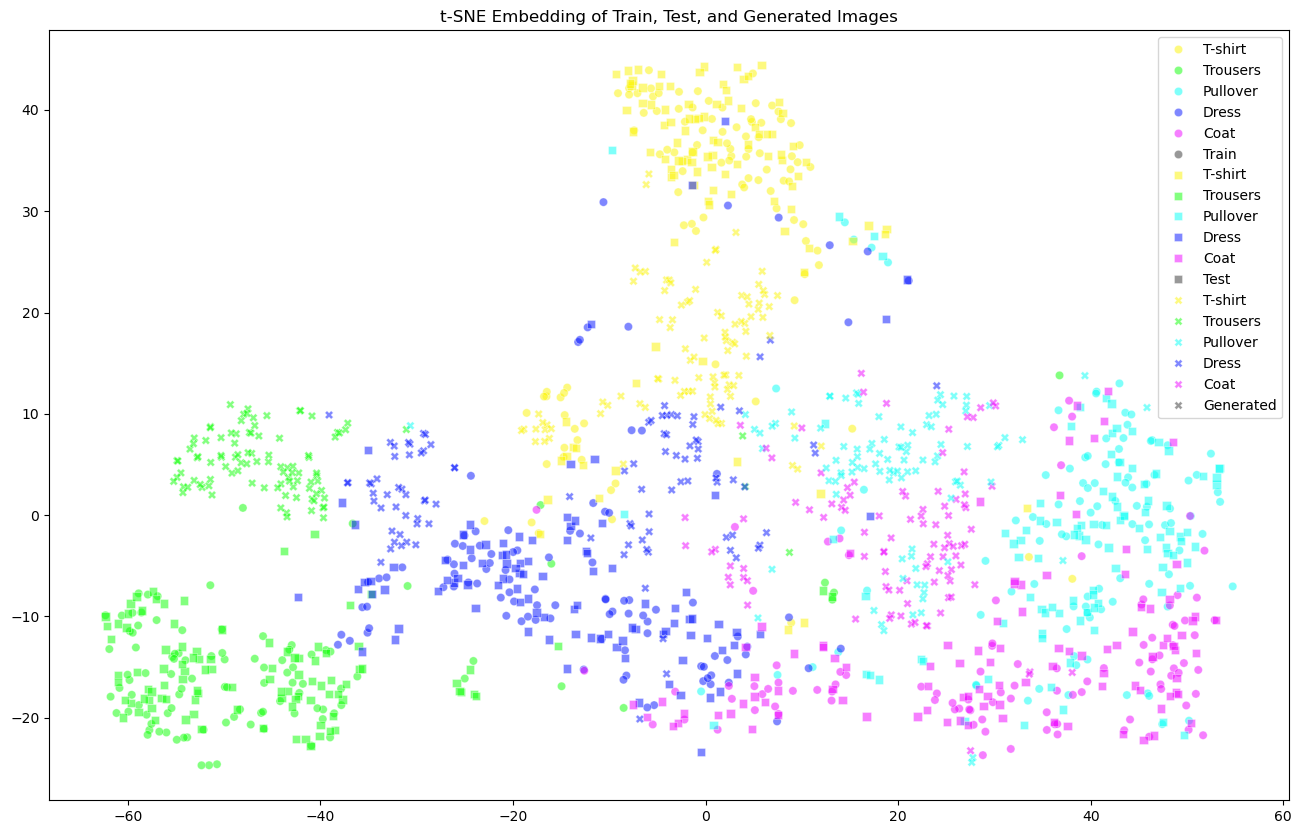

In [15]:
# Separate the results for visualization
tsne_train = tsne_results[:len(train_features)]
tsne_test = tsne_results[len(train_features):len(train_features) + len(test_features)]
tsne_generated = tsne_results[len(train_features) + len(test_features):]
classes = ['T-shirt', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# Map numeric labels to string labels
train_class = [classes[label] for label in train_labels]
test_class = [classes[label] for label in test_labels]
gen_class = [classes[label] for label in generated_labels]


# Visualization
plt.figure(figsize=(16, 10))

# train data
sns.scatterplot(
  x=tsne_train[:, 0], y=tsne_train[:, 1],
  hue=train_class,
  palette=sns.color_palette("hsv", num_classes),
  style=np.full(len(train_labels), 'Train'),
  markers=["o"],
  alpha=0.5
)

# test data
sns.scatterplot(
  x=tsne_test[:, 0], y=tsne_test[:, 1],
  hue=test_class,
  palette=sns.color_palette("hsv", num_classes),
  style=np.full(len(test_labels), 'Test'),
  markers=["s"],
  alpha=0.5
)

# generated data
sns.scatterplot(
    x=tsne_generated[:, 0], y=tsne_generated[:, 1],
    hue=gen_class,
    palette=sns.color_palette("hsv", num_classes),
    style=np.full(len(generated_labels), 'Generated'),
    markers=["X"],
    legend="brief",
    alpha=0.5,
)

plt.title('t-SNE Embedding of Train, Test, and Generated Images')
plt.legend()
plt.show()